In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from datetime import datetime
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.coordinates import builtin_frames
from astropy.coordinates import Angle

In [2]:
crab = SkyCoord.from_name('M1')

Text(0, 0.5, 'declination in deg')

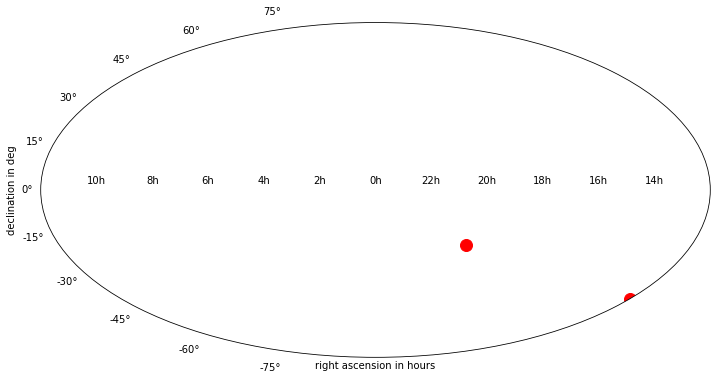

In [3]:
#plt.style.use('dark background')
plt.figure(figsize=(12,8))
plt.subplot(projection='aitoff')

plt.plot(5,30, color='r', marker='o', linestyle='None', markersize=12)
plt.plot(3,15, color='r', marker='o', linestyle='None', markersize=12)
plt.plot(22,-15, color='r', marker='o', linestyle='None', markersize=12)
plt.plot(13.5,-0.5, color='r', marker='o', linestyle='None', markersize=12)

plt.xticks(ticks=np.radians([-150,-120,-90,-60,-30,0,30,60,90,120,150]), labels=['10h','8h','6h','4h','2h','0h','22h','20h','18h','16h','14h'])
plt.xlabel('right ascension in hours')
plt.ylabel('declination in deg')

In [2]:
data = [0]*(199+201)
for i in range(0,199):
    with h5py.File('/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL2/20201118/dl2_LST-1.Run02929.{:04d}.h5'
               .format(i), 'r') as f:
        data[i] = pd.DataFrame(np.array(f['dl2/event/telescope/parameters/LST_LSTCam']))
        
for i in range(0,201):
    with h5py.File('/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL2/20201118/dl2_LST-1.Run02930.{:04d}.h5'
               .format(i), 'r') as f:
         data[199+i] = pd.DataFrame(np.array(f['dl2/event/telescope/parameters/LST_LSTCam']))
            
tot_data = pd.concat([data[i] for i in range(0,199+201)])
tot_data.head()

,intensity,log_intensity,x,y,r,phi,length,width,psi,skewness,...,log_reco_energy,reco_energy,reco_disp_dx,reco_disp_dy,reco_src_x,reco_src_y,reco_alt,reco_az,reco_type,gammaness
0,14019.949485,4.146746,-0.015204,-0.005036,0.016016,-2.821747,1.173447,1.142609,0.518989,0.023384,...,1.161159,14.493039,0.586236,0.238408,0.571033,0.233373,1.281348,1.902129,101,0.081857
1,76.737119,1.885005,-0.527041,-0.305895,0.609380,-2.615709,0.079877,0.073439,0.426368,0.060108,...,-1.459769,0.034692,-0.153171,-0.079658,-0.680212,-0.385553,1.236501,1.830964,101,0.386667
2,25.876774,1.412910,-0.349313,0.001244,0.349315,3.138032,0.088380,0.040477,0.769460,0.026443,...,-1.569809,0.026927,0.050654,0.022915,-0.298659,0.024159,1.250402,1.875670,101,0.305238
3,25.759664,1.410940,0.122801,-0.445033,0.461665,-1.301559,0.061317,0.053258,-1.157097,0.232783,...,-1.334617,0.046279,0.056081,-0.049218,0.178882,-0.494252,1.266962,1.813900,101,0.226262
4,44.028748,1.643736,-0.141567,0.933637,0.944309,1.721280,0.080193,0.045229,-1.103720,0.250541,...,-1.414461,0.038507,0.080160,0.050695,-0.061408,0.984333,1.256965,1.987032,101,0.251333


In [3]:
data = tot_data[(tot_data['gammaness']>0.8)]
data.shape

(3496, 50)

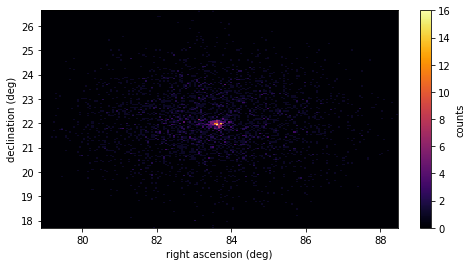

In [4]:
utc_time = []
for i in range(data.shape[0]):
    a = datetime.utcfromtimestamp(data.iloc[i,27])   #27 corresponds to the index of the column 'dragon_time'
    utc_time.append(a)
    
data = data.assign(utc_time = utc_time)   #add new column to the data frame with the UTC observation times of the events

loc = EarthLocation(lat = 28.76152611*u.deg, lon = -17.89149701*u.deg, height = 2184*u.m)   #location of the telescope (CTA LST1: Roque de los Muchachos)

hor_coords = SkyCoord(alt = data['reco_alt'], az = data['reco_az'], frame = 'altaz', unit = 'rad', 
                      obstime = data['utc_time'], location = loc)   #horizontal coordinates of the events
eq_coords = hor_coords.icrs   #equatorial coordinates of the events

data['RA'] = eq_coords.ra    #add columns with right ascension and declination (equatorial coordinates) of the events
data['DEC'] = eq_coords.dec

# skymap (RA, dec) de las posiciones reconstruidas de los sucesos (ya se ha aplicado el corte de gammaness > 0.8):
plt.figure(figsize=(8,4))
h = plt.hist2d(data['RA'], data['DEC'], bins = 175, cmap = 'inferno')
plt.xlabel('right ascension (deg)')
plt.ylabel('declination (deg)')
plt.colorbar(label='counts')

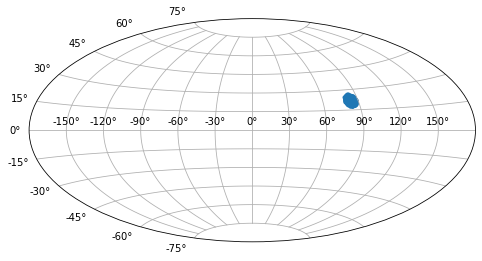

In [5]:
ra_rad = eq_coords.ra.wrap_at(180 * u.deg).radian
dec_rad = eq_coords.dec.radian

plt.figure(figsize=(8,4.2))
plt.subplot(111, projection='aitoff') 
plt.grid(True)
plt.scatter(ra_rad, dec_rad, marker='.')
plt.subplots_adjust(top=0.95,bottom=0.0)

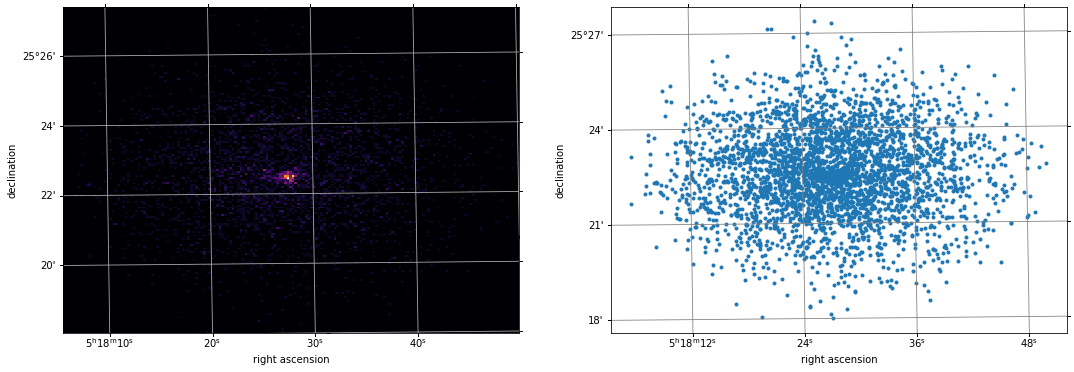

In [11]:
from astropy.wcs import WCS

wcs_dict = {'CTYPE1': 'RA---TAN', 'CUNIT1': 'deg', 'CDELT1': 1, 'CRPIX1': 1, 'CRVAL1': 78, 'NAXIS1': 1024,
    'CTYPE2': 'DEC--TAN', 'CUNIT2': 'deg', 'CDELT2': 1, 'CRPIX2': 1, 'CRVAL2': 25, 'NAXIS2': 1024}
wcs = WCS(wcs_dict)

plt.figure(figsize=(18,6))
plt.subplot(121, projection=wcs)
plt.hist2d(data['RA']*np.pi/180, data['DEC']*np.pi/180, bins = 175, cmap = 'inferno')
plt.xlabel('right ascension')
plt.ylabel('declination')

plt.subplot(122, projection=wcs)
plt.scatter(data['RA']*np.pi/180, data['DEC']*np.pi/180, marker='.')
plt.grid(color='gray', ls='solid')
plt.xlabel('right ascension')
plt.ylabel('declination')

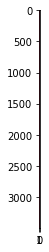

In [7]:
image = np.array([data['RA'], data['DEC']]).T
plt.imshow(image, cmap='inferno')

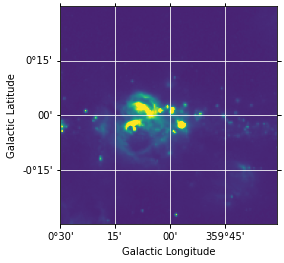

In [9]:
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

filename = get_pkg_data_filename('galactic_center/gc_msx_e.fits')

hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)

plt.subplot(projection=wcs)
plt.imshow(hdu.data, vmin=-2.e-5, vmax=2.e-4, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')